# 04.1 DAG Basics: The Language of Causality

**Chapter**: 4 - Graphical Causal Models  
**Section**: 1 - DAG Basics  
**Facure Source**: 04-Graphical-Causal-Models.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why Graphs?](#11-why-graphs)
   - 1.2 [Three Fundamental Structures](#12-three-fundamental-structures)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [DAG Definitions](#21-dag-definitions)
   - 2.2 [D-Separation](#22-d-separation)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Chains, Forks, and Colliders](#31-chains-forks-and-colliders)
   - 3.2 [Dependence Flow](#32-dependence-flow)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()
np.random.seed(42)

# For DAG visualization
try:
    import graphviz
    HAS_GRAPHVIZ = True
except ImportError:
    HAS_GRAPHVIZ = False
    print("Note: graphviz not installed. DAG diagrams will use text representation.")

---

## 1. Facure's Intuition

> **Interview Relevance**: DAGs are the lingua franca of causal inference. Being able to draw and interpret them is essential for any causal reasoning discussion.

### 1.1 Why Graphs?

DAGs (Directed Acyclic Graphs) provide a **transparent language** for causal thinking:

- **Nodes** = variables (random variables in your system)
- **Edges** (arrows) = direct causal relationships
- **Acyclic** = no variable can cause itself (no cycles)

Key insight: **Association flows along edges**, but causation only flows in the direction of arrows.

### 1.2 Three Fundamental Structures

Every DAG is built from three atomic structures:

| Structure | Shape | Example |
|-----------|-------|--------|
| **Chain** (Mediator) | A → B → C | Education → Job → Income |
| **Fork** (Common Cause) | A ← C → B | Rain ← Weather → Umbrella |
| **Collider** | A → C ← B | Looks → Dating ← Personality |

★ Insight ─────────────────────────────────────
- Chains and Forks: Conditioning on the middle node BLOCKS the path
- Colliders: Conditioning on the middle node OPENS the path
- This asymmetry is the key to understanding bias
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 DAG Definitions

**Directed Acyclic Graph (DAG)**:
- $G = (V, E)$ where $V$ = vertices (nodes), $E$ = directed edges
- Acyclic: No directed path from any node back to itself

**Key terminology**:
- **Parent** of $X$: Node with edge pointing to $X$
- **Child** of $X$: Node that $X$ points to
- **Ancestor**: Parent, or parent of parent, etc.
- **Descendant**: Child, or child of child, etc.
- **Path**: Sequence of connected nodes (ignoring arrow direction)

### 2.2 D-Separation

**Definition**: Two nodes $A$ and $B$ are **d-separated** by set $Z$ if every path between them is blocked.

**A path is blocked if**:
1. It contains a **chain** A → M → B or **fork** A ← M → B where M ∈ Z (conditioned on)
2. It contains a **collider** A → C ← B where C ∉ Z and no descendant of C is in Z

**D-separation implies conditional independence**:
$$A \perp\!\!\!\perp B \mid Z \iff A \text{ and } B \text{ are d-separated by } Z$$

This is the **Global Markov Property**: the graph encodes conditional independences.

---

## 3. Numeric Demonstration

### 3.1 Chains, Forks, and Colliders

In [2]:
# Simulate the three fundamental structures
np.random.seed(42)
n = 5000

# ==================
# CHAIN: A → B → C
# ==================
A_chain = np.random.normal(0, 1, n)
B_chain = 0.7 * A_chain + np.random.normal(0, 0.5, n)  # B depends on A
C_chain = 0.7 * B_chain + np.random.normal(0, 0.5, n)  # C depends on B

# ==================
# FORK: A ← C → B
# ==================
C_fork = np.random.normal(0, 1, n)  # Common cause
A_fork = 0.7 * C_fork + np.random.normal(0, 0.5, n)
B_fork = 0.7 * C_fork + np.random.normal(0, 0.5, n)

# ==================
# COLLIDER: A → C ← B
# ==================
A_collider = np.random.normal(0, 1, n)  # Independent
B_collider = np.random.normal(0, 1, n)  # Independent
C_collider = 0.5 * A_collider + 0.5 * B_collider + np.random.normal(0, 0.5, n)  # Common effect

print("THREE FUNDAMENTAL STRUCTURES")
print("="*60)

THREE FUNDAMENTAL STRUCTURES


In [3]:
def partial_correlation(x, y, z):
    """Compute partial correlation of x and y controlling for z."""
    # Residualize x and y on z
    x_resid = sm.OLS(x, sm.add_constant(z)).fit().resid
    y_resid = sm.OLS(y, sm.add_constant(z)).fit().resid
    return np.corrcoef(x_resid, y_resid)[0, 1]

# CHAIN: A → B → C
corr_AC_chain = np.corrcoef(A_chain, C_chain)[0, 1]
partial_AC_chain = partial_correlation(A_chain, C_chain, B_chain)

print("CHAIN: A → B → C")
print("-"*40)
print(f"Corr(A, C):           {corr_AC_chain:.3f}  (associated)")
print(f"Corr(A, C | B):       {partial_AC_chain:.3f}  (blocked by B)")
print("→ Conditioning on B BLOCKS the path\n")

CHAIN: A → B → C
----------------------------------------
Corr(A, C):           0.623  (associated)
Corr(A, C | B):       0.003  (blocked by B)
→ Conditioning on B BLOCKS the path



In [4]:
# FORK: A ← C → B
corr_AB_fork = np.corrcoef(A_fork, B_fork)[0, 1]
partial_AB_fork = partial_correlation(A_fork, B_fork, C_fork)

print("FORK: A ← C → B")
print("-"*40)
print(f"Corr(A, B):           {corr_AB_fork:.3f}  (spuriously associated)")
print(f"Corr(A, B | C):       {partial_AB_fork:.3f}  (blocked by C)")
print("→ Conditioning on C BLOCKS the spurious path\n")

FORK: A ← C → B
----------------------------------------
Corr(A, B):           0.665  (spuriously associated)
Corr(A, B | C):       -0.008  (blocked by C)
→ Conditioning on C BLOCKS the spurious path



In [5]:
# COLLIDER: A → C ← B
corr_AB_collider = np.corrcoef(A_collider, B_collider)[0, 1]
partial_AB_collider = partial_correlation(A_collider, B_collider, C_collider)

print("COLLIDER: A → C ← B")
print("-"*40)
print(f"Corr(A, B):           {corr_AB_collider:.3f}  (independent!)")
print(f"Corr(A, B | C):       {partial_AB_collider:.3f}  (OPENED by C!)")
print("→ Conditioning on C OPENS a spurious path\n")
print("This is 'explaining away' - knowing C makes A and B dependent.")

COLLIDER: A → C ← B
----------------------------------------
Corr(A, B):           -0.020  (independent!)
Corr(A, B | C):       -0.517  (OPENED by C!)
→ Conditioning on C OPENS a spurious path

This is 'explaining away' - knowing C makes A and B dependent.


### 3.2 Dependence Flow

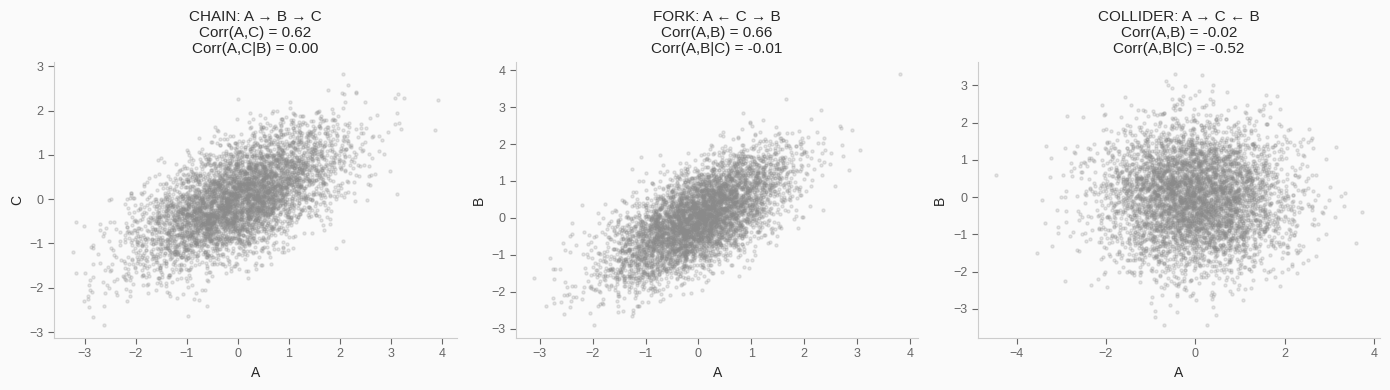

In [6]:
# Visualize all three structures
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Chain
ax = axes[0]
ax.scatter(A_chain, C_chain, alpha=0.2, s=5, c=TUFTE_PALETTE['secondary'])
ax.set_xlabel('A')
ax.set_ylabel('C')
ax.set_title(f'CHAIN: A → B → C\nCorr(A,C) = {corr_AC_chain:.2f}\nCorr(A,C|B) = {partial_AC_chain:.2f}')

# Fork
ax = axes[1]
ax.scatter(A_fork, B_fork, alpha=0.2, s=5, c=TUFTE_PALETTE['secondary'])
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.set_title(f'FORK: A ← C → B\nCorr(A,B) = {corr_AB_fork:.2f}\nCorr(A,B|C) = {partial_AB_fork:.2f}')

# Collider
ax = axes[2]
ax.scatter(A_collider, B_collider, alpha=0.2, s=5, c=TUFTE_PALETTE['secondary'])
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.set_title(f'COLLIDER: A → C ← B\nCorr(A,B) = {corr_AB_collider:.2f}\nCorr(A,B|C) = {partial_AB_collider:.2f}')

plt.tight_layout()
plt.show()

In [7]:
# Summary table
print("D-SEPARATION SUMMARY")
print("="*70)
print(f"{'Structure':<20} {'Unconditional':>15} {'Conditional':>15} {'Effect':>15}")
print("-"*70)
print(f"{'Chain (A→B→C)':<20} {'A ↔ C':>15} {'A ⊥ C | B':>15} {'BLOCKS':>15}")
print(f"{'Fork (A←C→B)':<20} {'A ↔ B':>15} {'A ⊥ B | C':>15} {'BLOCKS':>15}")
print(f"{'Collider (A→C←B)':<20} {'A ⊥ B':>15} {'A ↔ B | C':>15} {'OPENS':>15}")
print("-"*70)
print("↔ = associated, ⊥ = independent")

D-SEPARATION SUMMARY
Structure              Unconditional     Conditional          Effect
----------------------------------------------------------------------
Chain (A→B→C)                  A ↔ C       A ⊥ C | B          BLOCKS
Fork (A←C→B)                   A ↔ B       A ⊥ B | C          BLOCKS
Collider (A→C←B)               A ⊥ B       A ↔ B | C           OPENS
----------------------------------------------------------------------
↔ = associated, ⊥ = independent


---

## 4. Implementation

```python
# Using graphviz for DAG visualization
import graphviz

dag = graphviz.Digraph()
dag.node('T', 'Treatment')
dag.node('Y', 'Outcome')
dag.node('X', 'Confounder')

dag.edge('X', 'T')
dag.edge('X', 'Y')
dag.edge('T', 'Y')

dag.render('confounding_dag', format='png')

# Using DoWhy for causal discovery
from dowhy import CausalModel

model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    common_causes=['X'],
)
```

---

## 5. Interview Appendix

**Q1**: *"Draw a DAG representing confounding. What makes it confounding?"*

<details><summary>Solution</summary>

**DAG**: X → T, X → Y, T → Y

This is a **fork** with X as the common cause of both T and Y, plus a direct effect T → Y.

**What makes it confounding**:
- There's a **backdoor path**: T ← X → Y
- Association between T and Y comes from two sources:
  1. Causal: T → Y (what we want)
  2. Spurious: T ← X → Y (confounding bias)

**Solution**: Condition on X to block the backdoor path, isolating the causal effect.

</details>

**Q2**: *"What is d-separation? Why does it matter?"*

<details><summary>Solution</summary>

**D-separation** is a graphical criterion for determining whether two variables are conditionally independent given a set of variables.

**Rules**:
1. A path is **blocked** if it contains:
   - A chain or fork where the middle node is conditioned on, OR
   - A collider where neither it nor its descendants are conditioned on

2. Two nodes are **d-separated** by set Z if ALL paths between them are blocked by Z.

**Why it matters**: D-separation tells us:
- Which variables to control for (to block backdoor paths)
- Which variables NOT to control for (to avoid opening collider paths)
- Whether our identification strategy is valid

</details>

**Q3**: *"What's the difference between a mediator and a collider? Why does the distinction matter?"*

<details><summary>Solution</summary>

**Mediator (Chain)**: A → M → B
- M is on the causal pathway between A and B
- A causes M, M causes B
- Conditioning on M **blocks** the path (removes A-B association)

**Collider**: A → C ← B
- C is a common **effect** of A and B
- A and B are independent causes of C
- Conditioning on C **opens** a spurious path (creates A-B association)

**Why it matters**:
- For mediators: Condition to block unwanted paths
- For colliders: Do NOT condition, or you introduce bias
- Misidentifying a collider as a confounder leads to "selection bias"

Example: "Looks → Dating Success ← Personality" - conditioning on dating success (collider) creates spurious negative correlation between looks and personality.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 4.

[^2]: Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.

[^3]: Pearl, J., Glymour, M., & Jewell, N. P. (2016). *Causal Inference in Statistics: A Primer*. Wiley.